In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
matplotlib.rcParams.update({'font.size' : 14})

#### Вспомогательные функции

In [3]:
def ShowDistribution(X, column, roundcoef=1):
    target_mean = round(X[column].mean(), 2)
    target_median = X[column].median()
    target_mode = round(X[column] / roundcoef).mode()[0]*roundcoef 
    plt.figure(figsize = (16, 8))

    sns.distplot(X[column])
    y = np.linspace(0, 0.000005, 100)
    plt.plot([target_mean] * 100, y, label='mean', linestyle=':', linewidth=4)
    plt.plot([target_median] * 100, y, label='median', linestyle='--', linewidth=4)
    plt.plot([target_mode] * 100, y, label='mode', linestyle='-.', linewidth=4)

    plt.title('Distribution of ' + column)
    plt.legend()
    plt.show()

In [4]:
def ShowDistribution2(X, column):
    plt.figure(figsize = (16, 8))
    plt.subplot(121)
    X[column].hist()
    plt.ylabel('count')
    plt.xlabel(column)
    plt.subplot(122)
    sns.kdeplot(X[column], shade=True, legend=False)
    plt.xlabel(column)
    plt.suptitle('Distribution of ' + column)
    plt.show()

In [5]:
def Scatter(pt, xdata, ydata, title):
    pt.scatter(xdata,ydata)
    try:
        pt.set_title(title)   
    except:
        pt.title(title)

#### Загурзка данных

In [6]:
data = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')

y = data['Price']
X = data.drop(['Price'], axis='columns')
data_train, data_test, data_y_train, data_y_test = train_test_split(X, y, test_size=0.05, shuffle=True, random_state=40)

data = data_train
data['Price'] = data_y_train

#### Описание датасета:
Id - идентификационный номер квартиры  
DistrictId - идентификационный номер района  
Rooms - количество комнат  
Square - площадь  
LifeSquare - жилая площадь  
KitchenSquare - площадь кухни  
Floor - этаж  
HouseFloor - количество этажей в доме  
HouseYear - год постройки дома  
Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности  
Social_1, Social_2, Social_3 - социальные показатели местности  
Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья  
Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров  
Price - цена квартиры

***

#### Посмотрим структуру данных

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


***

***
***

### Начинаем изучать данные

In [8]:
data.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


###### Избавляемся от выбросов в Rooms   
1) Изучим квартиры с большим количеством комнат чем 5. Проверим их стоимость, площадь. в случае неакдекватных значений заменим количество на медиану.   


In [9]:
data["Rooms"] = np.int32(data["Rooms"])
data_test["Rooms"] = np.int32(data_test["Rooms"])
data.loc[data["Rooms"] > 5]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
377,5927,57,10,59.056975,36.223072,10.0,22,22.0,2002,0.090799,B,B,74,19083,2,NaN,5,15,B,317265.323792
1454,8491,1,19,42.006046,21.779288,7.0,17,17.0,2014,0.007122,B,B,1,264,0,NaN,0,1,B,78364.616704
2170,14003,99,6,59.414334,38.702244,6.0,7,9.0,1969,0.033494,B,B,66,10573,1,1322.0,3,8,B,229661.964416
8849,14865,9,10,60.871266,38.420681,10.0,3,2.0,1994,0.161532,B,B,25,5648,1,30.0,2,4,B,172329.270863


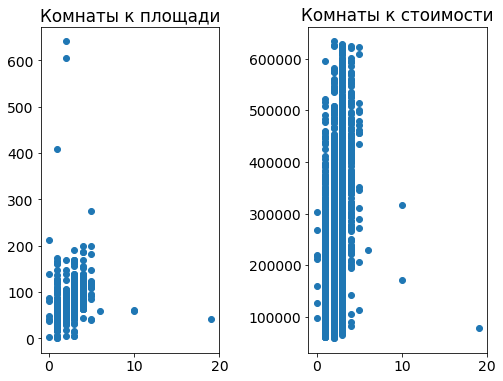

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=2)
Scatter(ax[0], data['Rooms'], data['Square'], 'Комнаты к площади')
Scatter(ax[1], data['Rooms'], data['Price'], 'Комнаты к стоимости')
fig.set_size_inches(8, 6)
fig.subplots_adjust(wspace=0.5, hspace=0.5)



Видно что все три квартиры относятся к выбросам. И одна несчастная 6 комнатная квартира тоже не к месту. Меняем на медиану.

In [11]:
data.loc[data["Rooms"] > 5, "Rooms"] = np.int32(data["Rooms"].median())
data_test.loc[data_test["Rooms"] > 5, "Rooms"] = np.int32(data_test["Rooms"].median())

2) Поступим аналогично для квартир без комнат.  


In [12]:
data.loc[data["Rooms"] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1397,12638,27,0,138.427694,136.215499,0.0,4,3.0,2016,0.075424,B,B,11,3097,0,NaN,0,0,B,268394.744389
1981,7917,27,0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,B,B,9,1892,0,NaN,0,1,B,302211.260887
2269,7317,27,0,41.790881,NaN,0.0,13,0.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,98129.976788
3911,770,28,0,49.483501,NaN,0.0,16,0.0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B,217009.338463
4366,456,6,0,81.491446,NaN,0.0,4,0.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,212864.799112
4853,3224,27,0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,126596.941798
6149,3159,88,0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,B,B,43,8429,3,NaN,3,9,B,158998.110646
8834,9443,27,0,87.762616,85.125471,0.0,5,15.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,219281.918007


In [13]:
data.loc[data["Rooms"] == 0, "Rooms"] = data["Rooms"].median()
data_test.loc[data_test["Rooms"] == 0, "Rooms"] = data_test["Rooms"].median()

***

###### Изучаем Square   
1) Построим ящик с усами, проверим как у нас распределются значения. 


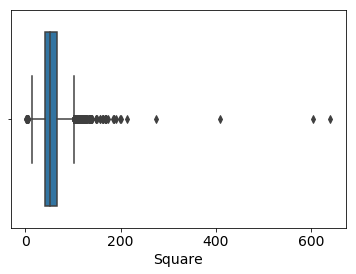

In [14]:
sns.boxplot(data['Square'])

2) Проверим квартиры с общей площадью < 15. Что это за кладовки такие...

In [15]:
data.loc[data["Square"] < 15].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
212,1748,88,2.0,5.497061,67.628717,1.0,24,22.0,1977,0.127376,B,B,43,8429,3,NaN,3,9,B,412511.088764
1316,11526,27,1.0,4.633498,1.969969,1.0,18,1.0,1977,0.011654,B,B,4,915,0,NaN,0,0,B,107604.269441
1608,10202,6,1.0,2.596351,4.604943,1.0,3,25.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,137597.601458
3280,10527,27,1.0,4.380726,40.805837,1.0,10,17.0,2013,0.211401,B,B,9,1892,0,NaN,0,1,B,97560.720383
3413,9487,5,1.0,5.129222,5.549458,1.0,1,1.0,1977,0.150818,B,B,16,3433,4,2643.0,4,5,B,369472.403061


Видим полнейшее безобразие в данных, жилая площадь больше общей, есть квартиры по одному квадратному метру.   
Применим такую хитрость: Для каждой неадекватной квартиры, возьмем медианное значение для квартир с таким же количеством комнат.

In [16]:
for i in range(1,6):
    data.loc[((data["Square"] < 15) & (data["Rooms"] == i)), "Square"] = data.loc[data["Rooms"] == i, "Square"].median()
    data_test.loc[((data_test["Square"] < 15) & (data_test["Rooms"] == i)), "Square"] \
        = data_test.loc[data_test["Rooms"] == i, "Square"].median()

In [17]:
for i in range(1,6):
    data.loc[((data["Square"] > 250) & (data["Rooms"] == i)), "Square"] = data.loc[data["Rooms"] == i, "Square"].median()
    data_test.loc[((data_test["Square"] > 250) & (data_test["Rooms"] == i)), "Square"] \
        = data_test.loc[data_test["Rooms"] == i, "Square"].median()

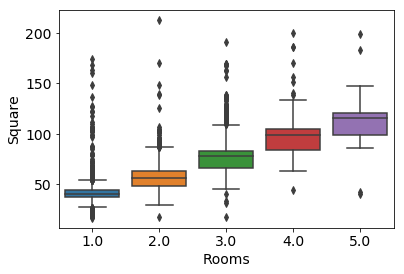

In [18]:
ax = sns.boxplot(x=data["Rooms"], y=data["Square"])

***

###### Избавляемся от выбросов и заполняем пропуски в LifeSquare. 

1) Заполняем пропуски по принципу медианная жилая площадь для квартир с таким же количеством комнат.

In [19]:
for i in range(1,7):
    data.loc[((pd.isna(data["LifeSquare"])) & (data["Rooms"] == i)), "LifeSquare"] \
        = data.loc[data["Rooms"] == i, "LifeSquare"].median()
    data_test.loc[((pd.isna(data_test["LifeSquare"])) & (data_test["Rooms"] == i)), "LifeSquare"] \
        = data_test.loc[data_test["Rooms"] == i, "LifeSquare"].median()    

2) Избавляемся от выбросов. Построим боксплоты для выбросов для квартир по комнатам.

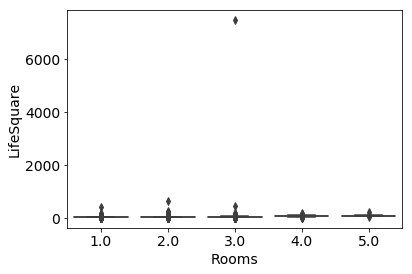

In [20]:
sns.boxplot(x=data["Rooms"], y=data["LifeSquare"])

3) Подробнее изучим самые неадекватные значения, если по данным будет чушь, подкорректируем жилую площадь медианным значением для квартир с таким количеством комнат.

In [21]:
data.loc[(data["LifeSquare"] > 200) | (data["LifeSquare"] < 6)].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
26,4378,27,3.0,106.958871,0.641822,0.0,17,0.0,2018,0.072158,B,B,2,629,1,NaN,0,0,A,337299.867936
95,4280,34,2.0,61.334968,4.091945,1.0,26,1.0,2014,0.069753,B,B,53,13670,4,NaN,1,11,B,286564.441972
134,12613,6,2.0,65.496674,5.589324,1.0,5,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,180727.643541
158,16779,27,3.0,51.991064,4.896202,1.0,22,25.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,174687.566186
160,3522,6,1.0,66.419841,3.987101,1.0,2,1.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,193361.229815


In [22]:
def FixLifeSquare(X):
    for i in range(1,6):
        X.loc[((data["LifeSquare"] > 200) | (data["LifeSquare"] < 6)) & (X["Rooms"] == i), "LifeSquare"]\
            = X.loc[X["Rooms"]==i, "LifeSquare"].median()    
    return X

In [23]:
data = FixLifeSquare(data)
data_test = FixLifeSquare(data_test)

4) Ещё раз взглянем на график

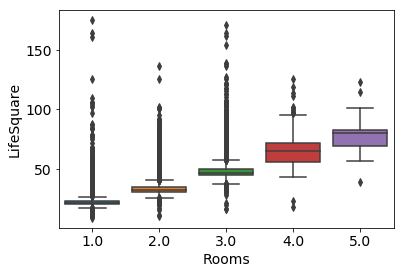

In [24]:
ax = sns.boxplot(x=data["Rooms"], y=data["LifeSquare"])

***

###### Удалим KitchenSquare     


In [25]:
data.drop(columns=["KitchenSquare"], inplace=True)
data_test.drop(columns=["KitchenSquare"], inplace=True)

***

###### Присмотримся к HouseFloor   
Проверим что все здания как минимум в 1 этаж. Если не так, то заменим медианой.

In [26]:
data["HouseFloor"] = np.int32(data["HouseFloor"])
data_test["HouseFloor"] = np.int32(data_test["HouseFloor"])
data.loc[data["HouseFloor"] < 1].shape

(269, 19)

In [27]:
data.loc[data["HouseFloor"] < 1, "HouseFloor"] = int(data["HouseFloor"].median())
data_test.loc[data_test["HouseFloor"] < 1, "HouseFloor"] = int(data_test["HouseFloor"].median())

***

###### Избавляемся от неадекватных данных в Floor

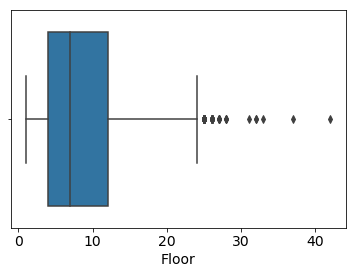

In [28]:
sns.boxplot(x=data["Floor"])

Выглядит более менее прилично. Проверим что этаж не больше чем максимальный этаж в доме. Ну и проверим, чтобы в подвалах не было квартир.

In [29]:
data.loc[(data["Floor"] < 1) | (data["Floor"] > data["HouseFloor"])].shape

(1610, 19)

А так всё хорошо начиналось... Заменим такие значения, медианой для этажности дома.

In [30]:
def FixFloor(X):
    for i in range(1,int(X["HouseFloor"].max())+1):
        if not X.loc[X["HouseFloor"] == i, "Floor"].empty:
            X.loc[( ((X["HouseFloor"] == i) & (X["Floor"] < 1) | (X["Floor"] > X["HouseFloor"]))), "Floor"] \
                = X.loc[(X["HouseFloor"] == i) & (X["HouseFloor"] >= X["Floor"]), "Floor"].median()   
    return X

In [31]:
data = FixFloor(data)
data_test = FixFloor(data_test)

***

###### Проверим что HouseYear адекватен

In [32]:
data.loc[data["HouseYear"] > 2020]

,Id,DistrictId,Rooms,Square,LifeSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1497,10814,109,1.0,37.265070,20.239714,9.0,12,20052011,0.136330,B,B,30,6141,10,262.0,3,6,B,254084.534396
4189,11607,147,2.0,44.791836,28.360393,4.0,9,4968,0.319809,B,B,25,4756,16,2857.0,5,8,B,243028.603096


In [33]:
data.loc[data["HouseYear"] > 2020, "HouseYear"] = int(data["HouseYear"].median())
data_test.loc[data_test["HouseYear"] > 2020, "HouseYear"] = int(data_test["HouseYear"].median())

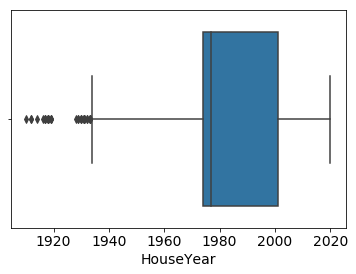

In [34]:
sns.boxplot(x=data["HouseYear"])

 ***

###### Проверяем Ecology_1, Ecology_2, Ecology_3

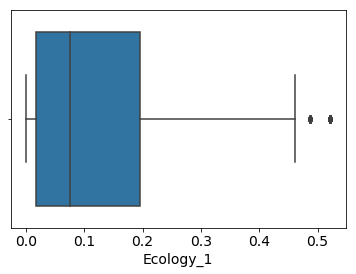

In [35]:
sns.boxplot(x=data["Ecology_1"])

In [36]:
data["Ecology_2"].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [37]:
data["Ecology_3"].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

Даже не строя графики видно что эти признаки очень сильно коррелируют и один из них следует удалить, а другой привратить в бинарный.

In [38]:
def PrettyEcology(X):
    X = pd.concat([X, pd.get_dummies(X["Ecology_2"])], axis=1)
    X.drop(['A','Ecology_2','Ecology_3'], axis='columns', inplace=True)
    X.rename(columns={'B': 'Ecology_B'}, inplace=True)
    return X

In [39]:
data = PrettyEcology(data)
data_test = PrettyEcology(data_test)

***

###### Избавляемся от пропусков в Healthcare_1

In [40]:
data.loc[data["Healthcare_1"].isnull()].shape

(4798, 18)

Почти половина... лучше удалить этот признак, а Helthcare_2 переименовать в Healthcare

In [41]:
data.drop(['Healthcare_1'], axis='columns', inplace=True)
data.rename(columns={'Helthcare_2': 'Healthcare'}, inplace=True)
data_test.drop(['Healthcare_1'], axis='columns', inplace=True)
data_test.rename(columns={'Helthcare_2': 'Healthcare'}, inplace=True)

***

###### Проверка Social_1, Social_2, Social_3

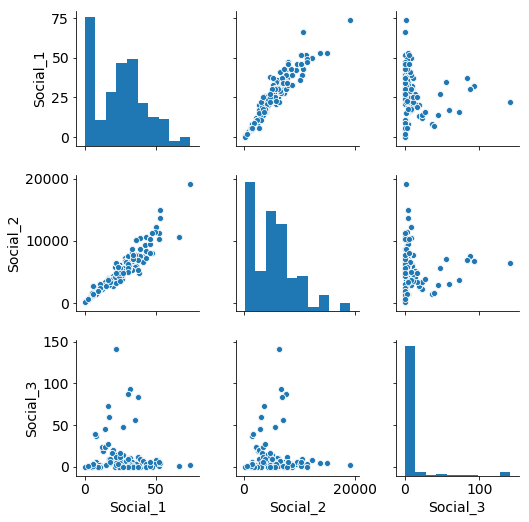

In [42]:
sns.pairplot(data[["Social_1", "Social_2", "Social_3"]])

Social_1 и Social_2 сильно коррелиируют. Удалим Social_2.

In [43]:
data.drop(['Social_2'], axis='columns', inplace=True)
data_test.drop(['Social_2'], axis='columns', inplace=True)

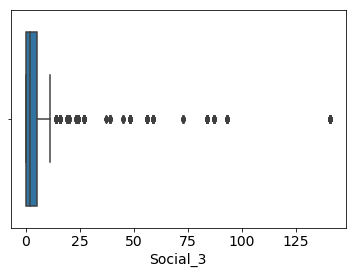

In [44]:
sns.boxplot(x=data["Social_3"])

In [45]:
data["Social_3"].quantile(.99)

141.0

In [46]:
data.loc[data["Social_3"] > 75., "Social_3"] = data["Social_3"].median()
data_test.loc[data_test["Social_3"] > 75., "Social_3"] = data_test["Social_3"].median()

***

###### Проверяем Shops_1, Shops_2

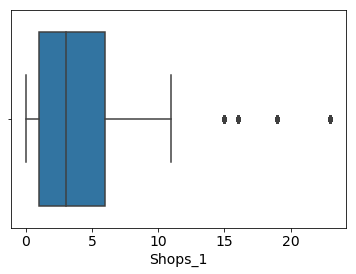

In [47]:
sns.boxplot(x=data["Shops_1"])

In [48]:
data["Shops_2"].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

Преобразуем Shops_2 в бинарный признак

In [49]:
def PrettyShops(X):
    X = pd.concat([X, pd.get_dummies(X["Shops_2"])], axis=1)
    X.drop(['A', 'Shops_2'], axis='columns', inplace=True)
    X.rename(columns={'B': 'Shops_B'}, inplace=True)
    return X

In [50]:
data = PrettyShops(data)
data_test = PrettyShops(data_test)

***

###### Проверяем Price

In [51]:
data["Price"].describe()

count     10000.000000
mean     214138.857399
std       92872.293865
min       59174.778028
25%      153872.633942
50%      192269.644879
75%      249135.462171
max      633233.466570
Name: Price, dtype: float64

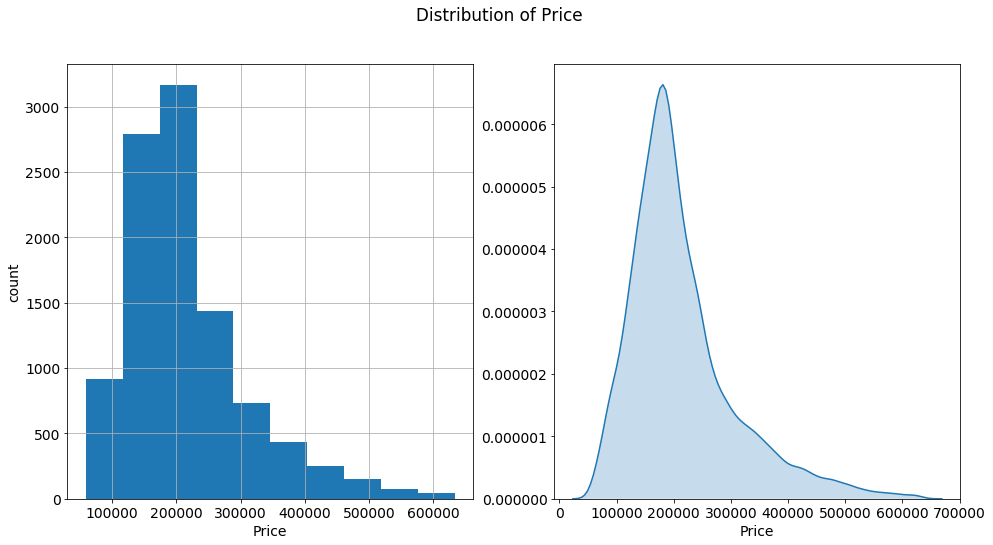

In [52]:
ShowDistribution2(data, "Price")

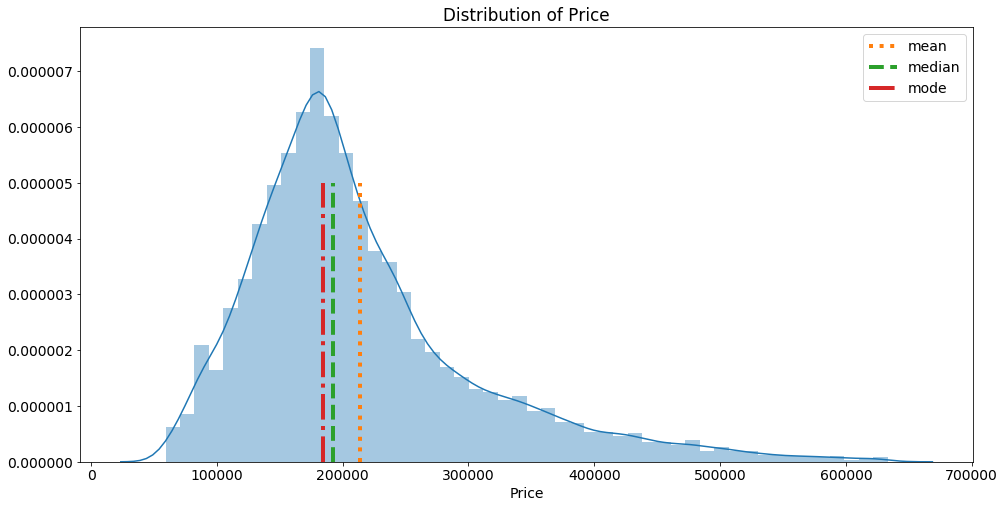

In [53]:

ShowDistribution(data, 'Price', 1000)

Вроде всё выглядит хорошо.

***
***

#### Проверка логической не противоричивости признаков

###### Проверим логическую непротиворичивость по общей площади.

In [54]:
data["other_square"] = data["Square"] - data["LifeSquare"]
data_test["other_square"] = data_test["Square"] - data_test["LifeSquare"]

In [55]:
data.loc[data["other_square"] < 0].shape

(475, 17)

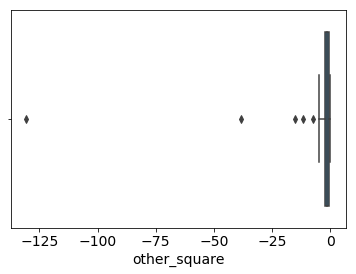

In [56]:
sns.boxplot(x=data.loc[data["other_square"] < 0, 'other_square'])

Примечательно, что есть выбросы даже среди противоречивых значений. Попробуем поступить кардинально и сделать Square = LifeSquare

In [57]:
data.loc[data["other_square"] < 0, "Square"]\
        = data.loc[data["other_square"] < 0, "LifeSquare"]
data_test.loc[data_test["other_square"] < 0, "Square"]\
        = data_test.loc[data_test["other_square"] < 0, "LifeSquare"]

In [58]:
data["other_square"] = data["Square"] - data["LifeSquare"]
data_test["other_square"] = data_test["Square"] - data_test["LifeSquare"]

   
***   
***   
***

### Расширение признакового пространства

In [59]:
def CreatePriceFeature(df, columns, featurename):
    return df.groupby(columns)[['Price']]\
                    .median().reset_index()\
                    .rename(columns={'Price':featurename})
    

In [60]:
def MergePriceFeature(df, columns, featurename, feature):
    df = pd.merge(df, feature, on=columns, how='left')
    df.loc[df[featurename].isnull(), featurename]\
        = df[featurename].median()    
    return df

In [61]:
def ExpandDataOnPriceFeature(df, df_test, columns, featurename):
    feature = CreatePriceFeature(df,columns, featurename)
    df =  MergePriceFeature(df, columns, featurename, feature)
    df_test =  MergePriceFeature(df_test, columns, featurename, feature)
    return (df, df_test)

In [62]:
data, data_test = ExpandDataOnPriceFeature(data, data_test, ['DistrictId'], 'mean_price_by_district')
data, data_test = ExpandDataOnPriceFeature(data, data_test, ['DistrictId','Rooms'], 'mean_price_by_roomd')
data, data_test = ExpandDataOnPriceFeature(data, data_test, ['DistrictId','Healthcare'], 'mean_price_by_healthcared')
data, data_test = ExpandDataOnPriceFeature(data, data_test, ['DistrictId','Social_1'], 'mean_price_by_social1d')
data, data_test = ExpandDataOnPriceFeature(data, data_test, ['DistrictId','Ecology_B'], 'mean_price_by_ecology_bd')
data, data_test = ExpandDataOnPriceFeature(data, data_test, ['Rooms'], 'mean_price_by_room')
data, data_test = ExpandDataOnPriceFeature(data, data_test, ['Shops_1'], 'mean_price_by_shops_1')
#data, data_test = ExpandDataOnPriceFeature(data, data_test, ['DistrictId','Shops_B'], 'mean_price_by_shops_b2')


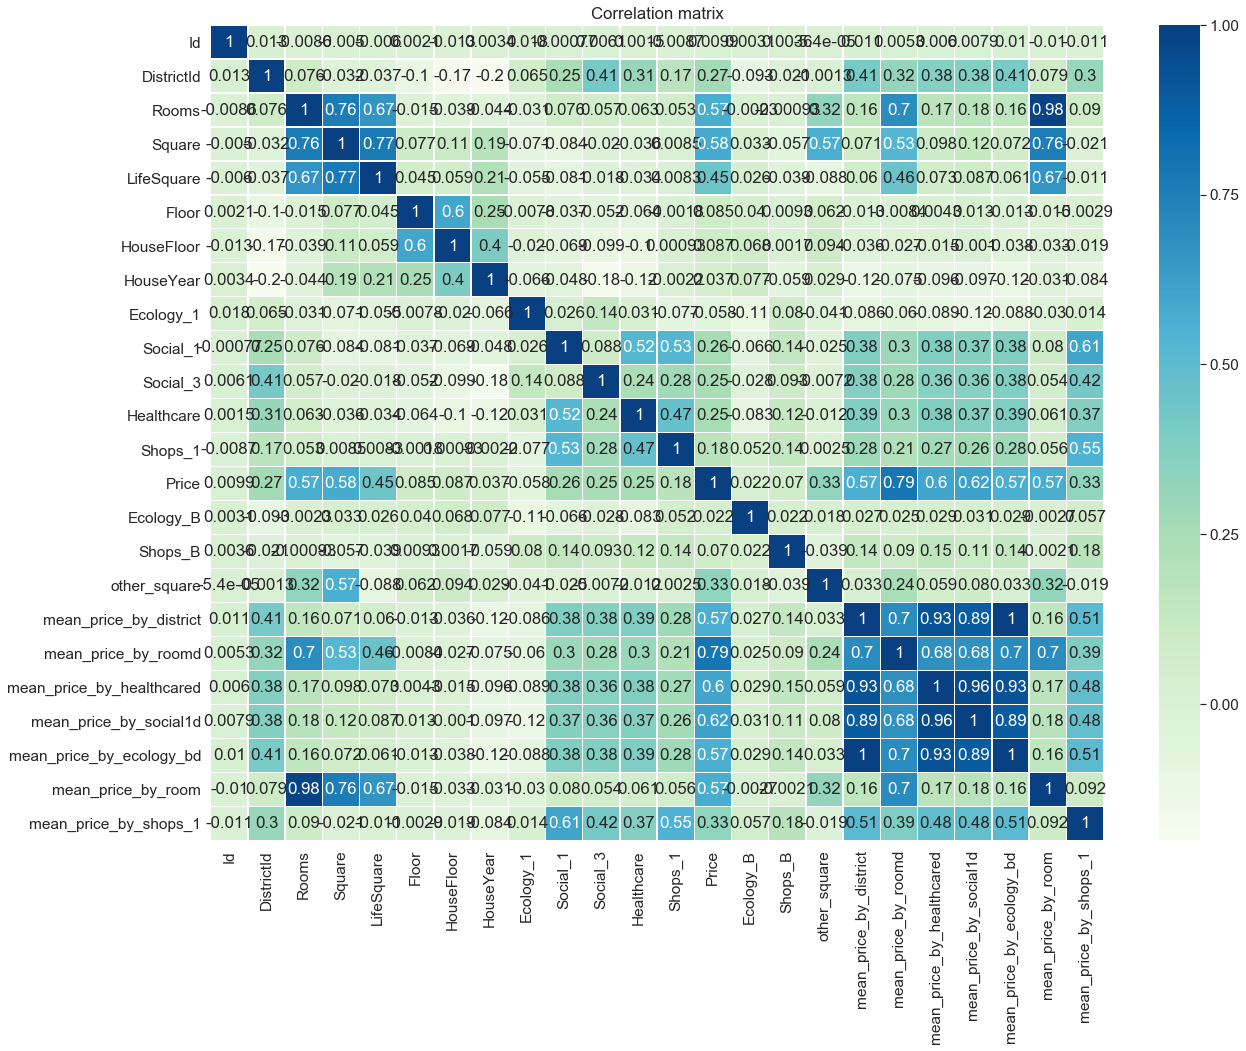

In [63]:
plt.figure(figsize = (20,15))

sns.set(font_scale=1.4) 
sns.heatmap(data.corr(), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix') 
plt.show()

***

##### Сделаем индекс из Id

In [64]:
data.set_index(["Id"], inplace=True)
data_test.set_index(["Id"], inplace=True)

### Обучение модели

In [65]:
y = data['Price']
X = data.drop(['Price'], axis='columns')


In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [67]:
gb_model = GradientBoostingRegressor(random_state=100)

In [68]:
params = {'n_estimators':[50, 100, 200],  'max_depth':list(range(3,8))}

gs = GridSearchCV(gb_model, params, scoring='r2', cv=KFold(n_splits=3, random_state=21, shuffle=True), n_jobs=-1)


In [69]:
gs.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
       error_score='raise-deprecating',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...e=100, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [50, 100, 200], 'max_depth': [3, 4, 5, 6, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [70]:
gs.best_params_

{'max_depth': 4, 'n_estimators': 200}

In [71]:
y_pred = gs.predict(X_test)
r2(y_test, y_pred)

0.7622342539027109

In [72]:
y_pred = gs.predict(data_test)

###### Сохраняем результаты

In [78]:
result = pd.DataFrame(data_test.reset_index()["Id"])
result['Price'] = y_pred

In [82]:
result.to_csv('GusevAA_predictions.csv', index=False)